## Models Testing and comparaisons

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

from FI_FCM import FI_FCM
from S_FCM import S_FCM

import matplotlib.pyplot as plt
import itertools
import copy
import numpy as np

DATASETS_PATHS = ['datasets/melanomaTest.dat.csv', 'datasets/seeds_dataset.csv', 'datasets/CancerDiag2_headers.csv', 'datasets/Leukemia_Mile_210.csv'] # http://cibcb.org/data/

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading datasets

In [2]:
def loadDataset(filename):
    dataset = np.genfromtxt(filename, delimiter=';')
    
    # save all the labels to calculate the performance of our algorithm
    true_labels = copy.copy(dataset[:, -1])
    labels_names = np.unique(true_labels)
    
    return dataset, true_labels, labels_names

DATASETS = []
for path in DATASETS_PATHS:
    DATASETS.append(loadDataset(path))
    

## Parameters

In [3]:
index_dataset = 3
percentage_ommission = 80
dataset = DATASETS[index_dataset][0]
true_labels = DATASETS[index_dataset][1]
labels_names = DATASETS[index_dataset][2]
algo = 1 # 0 for FI-FCM, 1 for S-FCM

## Remove some labels

In [4]:
def removeLabels_FI(dataset, labels_name, percentage):  
    result = copy.copy(dataset)
    # remove percentage of each different labels for test purpose       
    for label in labels_name:
        subArrayIdx = np.where(result[:,-1] == label)[0]
        if len(subArrayIdx):
            idx = np.random.choice(subArrayIdx, int(len(subArrayIdx)*percentage/100), replace=False)
            for i in idx:
                result[i][-1] = 0
    return result

def removeLabels_S(dataset, labels_name, percentage):  
    col = np.zeros((len(dataset), 1), float)
    for i in range(len(dataset)):
        col[i] = dataset[i][-1]

    dataset = np.append(dataset, np.asarray(col), axis = 1)
    result = copy.copy(dataset)
    # remove percentage of each different labels for test purpose       
    for label in labels_name:
        subArrayIdx = np.where(result[:,-2] == label)[0]
        idx = np.random.choice(subArrayIdx, int(len(subArrayIdx)*percentage/100), replace=False)
        for i in idx:
            result[i][-2] = 0   

    return result

if algo == 0:
    dataset = removeLabels_FI(dataset, labels_names, percentage_ommission)
else : 
    dataset = removeLabels_S(dataset, labels_names, percentage_ommission)

## Perform Tests

In [5]:
if algo == 0:
    fcm = FI_FCM() 
    fcm.setParams(fuzzy_param=2, membership_threshold=0.95)
    labels, centers, mb = fcm.clusterize(dataset, labels_names)
else:
    fcm = S_FCM()
    fcm.setParams(fuzzy_param=2, membership_threshold=0.95)
    new_data, labels, centers, mb = fcm.clusterize(dataset, labels_names)

### Confusion Matrix and scores

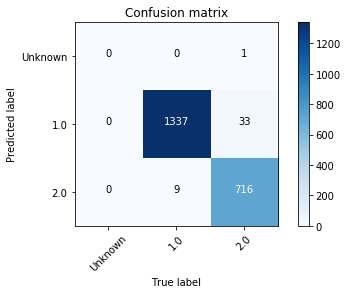

In [6]:
if algo == 0:
    conf_mat = confusion_matrix(labels, true_labels)
else: 
    conf_mat = confusion_matrix(labels,new_data[:, -1])
    
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    if 0 in labels:
        labels_names_ref = np.append(["Unknown"], labels_names)
    else:
        labels_names_ref = labels_names
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels_names_ref))
    plt.xticks(tick_marks, labels_names_ref, rotation=45)
    plt.yticks(tick_marks, labels_names_ref)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
plot_confusion_matrix(conf_mat)

In [7]:
print("Accuracy:", accuracy_score(labels, true_labels))
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)

Accuracy: 0.8368320610687023
Precision:  nan
Recall:  nan
F1-Score:  nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


### Parameters Exploration

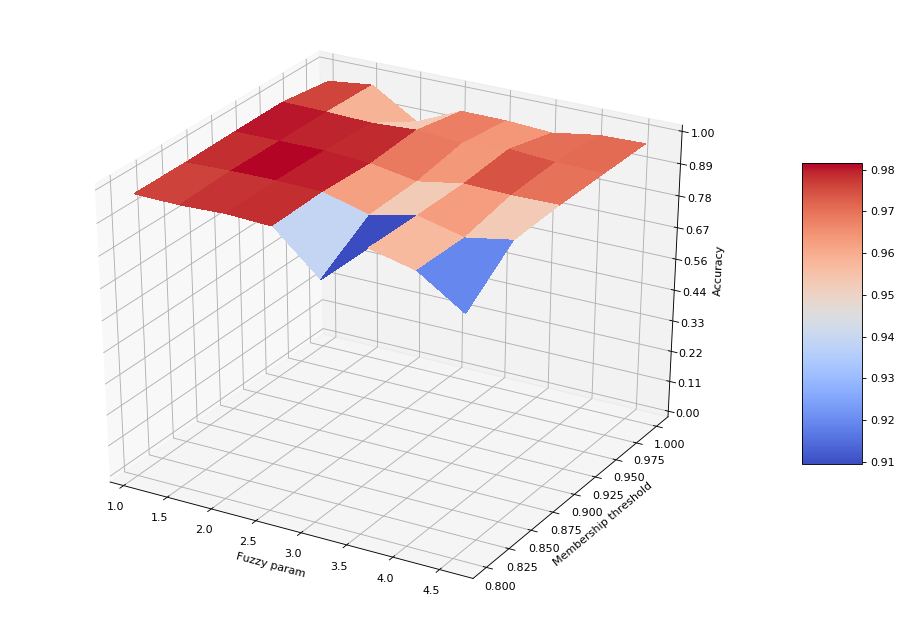

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fuzzy_params = np.arange(1.1,5,0.5)
mb_threshold_values = np.arange(0.8,1.05,0.05)

def computeClustering(fuzzy_param, mb_threshold_value):
    if algo == 0:
        fcm.setParams(fuzzy_param=fuzzy_param, membership_threshold=mb_threshold_value)
        labels, centers, mb = fcm.clusterize(dataset, labels_names)
        return accuracy_score(labels, true_labels)
    else: 
        fcm.setParams(fuzzy_param=fuzzy_param, membership_threshold=mb_threshold_value)
        new_data, labels, centers, mb = fcm.clusterize(dataset, labels_names)
        return accuracy_score(labels, [row[-1] for row in new_data])

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

# Make data.
fuzzy_params, mb_threshold_values = np.meshgrid(fuzzy_params, mb_threshold_values)

accurencies = np.array([computeClustering(x,y) for x,y in zip(np.ravel(fuzzy_params), np.ravel(mb_threshold_values))])
accurencies = accurencies.reshape(mb_threshold_values.shape)

graph = ax.plot_surface(fuzzy_params, mb_threshold_values, accurencies, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Fuzzy param')
ax.set_ylabel('Membership threshold')
ax.set_zlabel('Accuracy')

# Customize the z axis.
ax.set_zlim(0, 1.00)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(graph, shrink=0.5, aspect=5)

plt.show()

### Number of clusters and percentage of unlabeled data exploration

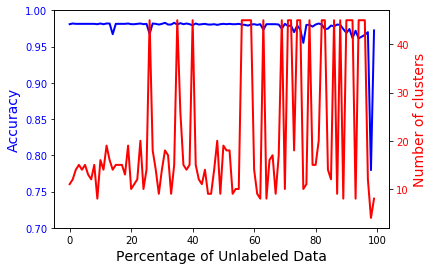

In [9]:
def computeClustering(percentageOmission):
    if algo == 0:
        temp_dataset = removeLabels_FI(dataset, labels_names, percentageOmission) 
        fcm.setParams(fuzzy_param=1.5, membership_threshold=0.925)
        labels, centers, mb = fcm.clusterize(temp_dataset, labels_names)    
        return accuracy_score(labels, true_labels), len(centers)
    else:
        temp_dataset = removeLabels_S(dataset, labels_names, percentageOmission) 
        fcm.setParams(fuzzy_param=1.5, membership_threshold=0.925)
        new_data, labels, centers, mb = fcm.clusterize(temp_dataset, labels_names)    
        return accuracy_score(labels, [row[-1] for row in new_data]), len(centers)

labelOmission = np.arange(0, 100)
accurencies = np.array([computeClustering(x) for x in labelOmission])
nb_cluster = accurencies[:, -1]
accurencies = accurencies[:, 0]
nb_cluster.astype(int)
fig, ax1 = plt.subplots()

ax1.plot(labelOmission, accurencies, lw=2, color="blue")
ax1.set_ylabel("Accuracy", fontsize=14, color="blue")
for label in ax1.get_yticklabels():
    label.set_color("blue")
plt.ylim(0.70, 1)
ax2 = ax1.twinx()
ax2.plot(labelOmission, nb_cluster, lw=2, color="red")
ax2.set_ylabel("Number of clusters", fontsize=14, color="red")
for label in ax2.get_yticklabels():
    label.set_color("red")
    
ax1.set_xlabel(r'Percentage of Unlabeled Data', fontsize=14)
#ax1.set_title('FI-FCM accurency depending on the percentage of labelised data', fontsize=14);

plt.show()

### Rules extraction

In [10]:
def createDecisionTree(dataset):
    #split the dataset
    X = dataset[:,0:-2]
    Y = dataset[:,-1]
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
    
    # Create and train the decision tree
    tree = DecisionTreeClassifier(criterion = "entropy", random_state = 100)
    tree.fit(X_train, y_train)
    
    # Test our tree
    y_pred = tree.predict(X_test)
    print ("Tree Accuracy is ", accuracy_score(y_test,y_pred)*100)
    return tree

def extractRules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
dataset[:,-1] = labels

extractRules(createDecisionTree(dataset), ["feature_"+ str(i) for i in range(len(dataset[0] - 1))])

Tree Accuracy is  80.44515103338632
def tree(feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_35, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, feature_68, feature_69, feature_70, feature_71, feature_72, feature_73, feature_74, feature_75, feature_76, feature_77, feature_78, feature_79, featu

### Algorithms Comparison

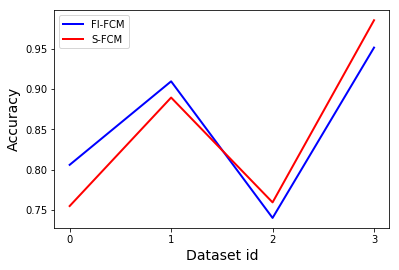

In [11]:
fcm_1 = FI_FCM()
fcm_1.setParams(fuzzy_param=2, membership_threshold=0.95)
fcm_2 = S_FCM()
fcm_2.setParams(fuzzy_param=2, membership_threshold=0.95)

def computeClustering_1(datasetIndex):
    dataset = DATASETS[datasetIndex][0]
    true_labels = DATASETS[datasetIndex][1]
    labels_names = DATASETS[datasetIndex][2]
    
    dataset = removeLabels_FI(dataset, labels_names, 0) 
    fcm.setParams(fuzzy_param=1.5, membership_threshold=0.925)
    labels, centers, mb = fcm_1.clusterize(dataset, labels_names)
    return accuracy_score(labels, true_labels), len(centers)

def computeClustering_2(datasetIndex):
    dataset = DATASETS[datasetIndex][0]
    true_labels = DATASETS[datasetIndex][1]
    labels_names = DATASETS[datasetIndex][2]
    dataset = removeLabels_S(dataset, labels_names, 0) 
    fcm.setParams(fuzzy_param=1.5, membership_threshold=0.925)
    new_data, labels, centers, mb = fcm_2.clusterize(dataset, labels_names)
    return accuracy_score(labels, [row[-1] for row in new_data]), len(centers)


datasets = np.array(range(len(DATASETS)))
result_fcm_1 = np.array([computeClustering_1(x) for x in datasets])
nb_cluster_fcm_1 = result_fcm_1[:, -1]
accurencies_fcm_1 = result_fcm_1[:, 0]
result_fcm_2 = np.array([computeClustering_2(x) for x in datasets])
nb_cluster_fcm_2 = result_fcm_2[:, -1]
accurencies_fcm_2 = result_fcm_2[:, 0]
nb_cluster_fcm_1.astype(int)
nb_cluster_fcm_2.astype(int)

fig, ax1 = plt.subplots()

ax1.plot(["0", "1", "2", "3"], accurencies_fcm_1, lw=2, color="blue", label="FI-FCM")
ax1.plot(["0", "1", "2", "3"], accurencies_fcm_2, lw=2, color="red", label="S-FCM")

ax1.legend()
ax1.set_ylabel("Accuracy", fontsize=14)
ax1.set_xlabel(r'Dataset id', fontsize=14)
#ax1.set_title('Accuracy and clusters comparison between FI-FCM and S-FCM ', fontsize=14);

plt.show()